# CIFAR10 with MLPs
Simple starter notebook to benchmark your own MLP with PyTorch on the CIFAR-10 dataset.

OBS.:

- The main code is basically done, so focus on training the models and searching for the best hyperparameters and architectures.
- You are not required to use this exact code or even the PyTorch library.
- It is recommended to use execution environments with GPU access (such as Google Colab), since larger models will take more time to train.
- Remember to document the history of your experiments and which results motivated the changes in subsequent experiments.

## Como tentamos melhorar o modelo:
- Utilizamos o optuna para encontrar melhores hiperparâmetros: learning rate, número de nós em cada camada e função de ativação
- Evitar overfiting:
    - Regularização com weight_decay no otimizador para diminuir a magnitude dos pesos
    - Uso de dropout para desativar 20% dos neurônios
    - separação do dataset de treinamento em treinamento e validação
    - Uso de early stopping levando em conta o loss da validação
    - Uso de label smoothing para evitar confiança excessiva
- Teste de diferentes otimizadores
  - ADAM
  - SGD com momentum
- Alteração na Patience e número de épocas


In [1]:
%pip install optuna
%pip install torch
%pip install torchvision
%pip install scikit-learn
%pip install matplotlib
%pip install numpy
%pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [2]:
#@title Libs

import torch
from torch.utils.data import DataLoader

import torchvision
import torch.nn as nn
from torchvision import datasets, transforms

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Subset

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

from tqdm import tqdm

import os
from collections import Counter

import optuna

# Data exploration

Quando usamos transforms.ToTensor(), a imagem (que antes era H x W x C) vira um tensor com shape: C x H x W

O matplotlib.pyplot.imshow() espera a imagem no formato H x W x C (como a maioria das bibliotecas de imagem em Python).


In [3]:
# Função para "desnormalizar" e mostrar imagens
def imshow(img):
    img = img / 2 + 0.5  # desfaz a normalização
    img = torch.clamp(img, 0, 1)  # limita os valores ao intervalo [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform= transform)

100%|██████████| 170M/170M [00:04<00:00, 41.5MB/s]


In [5]:
# Extraímos todos os rótulos do dataset de treino e ignoramos as imagens
labels = [label for _, label in dataset]

# Contamos quantas vezes cada rótulo aparece
label_counts = Counter(labels)

# Imprimimos o resultado com nome da classe
for class_idx, count in label_counts.items():
    class_name = dataset.classes[class_idx]
    print(f'{class_name}: {count} imagens')

frog: 5000 imagens
truck: 5000 imagens
deer: 5000 imagens
automobile: 5000 imagens
bird: 5000 imagens
horse: 5000 imagens
ship: 5000 imagens
cat: 5000 imagens
dog: 5000 imagens
airplane: 5000 imagens


In [6]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
def showImagesInLoader(loader):
    # Itera no loader e mostra imagens
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # Mostra as imagens
    imshow(torchvision.utils.make_grid(images))

    # Mostra os rótulos correspondentes
    print(' '.join(f'{dataset.classes[label]}' for label in labels))

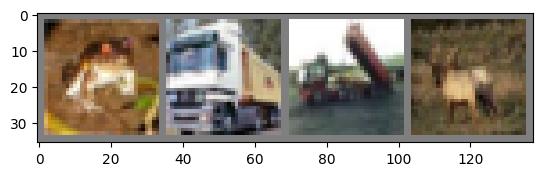

frog truck truck deer


In [8]:
loader = DataLoader(dataset, batch_size=4, shuffle=False)

showImagesInLoader(loader)

Scores of the first model:
  'accuracy': 0.474, 'balanced_accuracy': np.float64(0.47400000000000003), 'precision': 0.4788458695520801, 'recall': 0.474, 'f1_score': 0.4749641894435279



Adding Gaussinan Noise:
Scores of your model
 {'accuracy': 0.529, 'balanced_accuracy': np.float64(0.5289999999999999), 'precision': 0.5276866099986426, 'recall': 0.529, 'f1_score': 0.5264172516467065}

Começamos a treinar uma mlp com 4 camadas usando imagens com 3 canais (RGB) , depois transformamos as imagens para a escala de cinza

In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

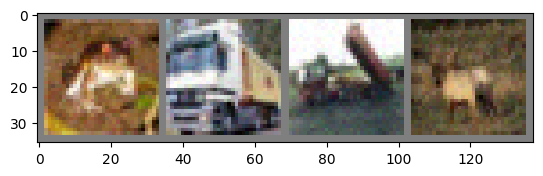

frog truck truck deer


In [10]:
#@title Dataset Setup

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    AddGaussianNoise(mean=0.0, std=0.05)
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

                                       # Itera no loader e mostra imagens
loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

showImagesInLoader(loader)


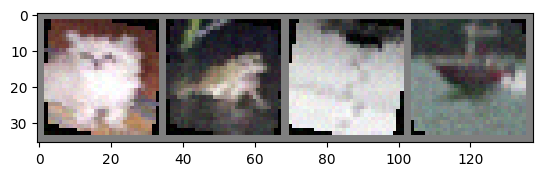

cat frog airplane ship


In [11]:
# Definindo transformações de data augmentation com gaussian noise
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, shear=5),
    transforms.RandomApply([transforms.RandomGrayscale(p=1.0)], p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(1, 1), sigma=(0.1, 2.0))], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    AddGaussianNoise(mean=0.0, std=0.05)
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

augmented_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
showImagesInLoader(augmented_loader)

In [12]:
#@title Dataset Setup

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    AddGaussianNoise(mean=0.0, std=0.05)
])

train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


In [13]:
# Extrai os rótulos
targets = np.array(train_val_dataset.targets)

# Cria o validador estratificado
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Gera os índices
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_dataset = Subset(train_val_dataset, train_idx)
    val_dataset = Subset(train_val_dataset, val_idx)

In [14]:
# Acessa os rótulos (targets) do val_dataset
val_targets = [train_val_dataset[idx][1] for idx in val_dataset.indices]

# Conta quantas vezes cada classe aparece
val_distribution = Counter(val_targets)

print("Distribuição de classes no val_dataset:")
for label, count in sorted(val_distribution.items()):
    print(f"Classe {label}: {count} amostras")

Distribuição de classes no val_dataset:
Classe 0: 1000 amostras
Classe 1: 1000 amostras
Classe 2: 1000 amostras
Classe 3: 1000 amostras
Classe 4: 1000 amostras
Classe 5: 1000 amostras
Classe 6: 1000 amostras
Classe 7: 1000 amostras
Classe 8: 1000 amostras
Classe 9: 1000 amostras


In [15]:
#@title Loaders
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
#@title Defining the MLP model

class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, num_classes, activation_function):
        super(MLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, hidden1),
            activation_function,
            nn.Dropout(0.2),
            nn.Linear(hidden1, hidden2),
            activation_function,
            nn.Dropout(0.2),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

## Hyperparameters Study



In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

input_size = 32*32*3 # 32*32 RGB images

def objective(trial):

    # Hiperparâmetros sugeridos pelo Optuna
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    hidden1 = trial.suggest_int("hidden1", 64, 256)
    hidden2 = trial.suggest_int("hidden2", 64, 256)
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "ELU"])

    activation_fn = getattr(nn, activation_name)()

    # Dataset e DataLoader (usa apenas um subset para acelerar)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset, _ = torch.utils.data.random_split(train_dataset, [5000, len(train_dataset)-5000])
    train_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

    model = MLP(input_size,
                hidden1= hidden1,
                hidden2= hidden2,
                num_classes = 10,
                activation_function = activation_fn)

    model.to(device)
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Treinamento simples de 1-3 épocas (rápido)
    for epoch in range(3):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.view(-1, input_size).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Retorna a perda média como métrica a minimizar
    return running_loss / len(train_loader)

cuda


In [25]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-06-02 00:31:39,723] A new study created in memory with name: no-name-3a1edbef-045e-4532-a37c-5cd27e52dd30
[I 2025-06-02 00:31:44,669] Trial 0 finished with value: 1.8122791263121594 and parameters: {'lr': 0.005254209477984414, 'hidden1': 101, 'hidden2': 66, 'activation': 'ELU'}. Best is trial 0 with value: 1.8122791263121594.
[I 2025-06-02 00:31:49,271] Trial 1 finished with value: 2.304768148856827 and parameters: {'lr': 4.713396629897016e-05, 'hidden1': 240, 'hidden2': 125, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 1.8122791263121594.
[I 2025-06-02 00:31:53,743] Trial 2 finished with value: 2.267505087429964 and parameters: {'lr': 3.9279052162108286e-05, 'hidden1': 82, 'hidden2': 85, 'activation': 'ELU'}. Best is trial 0 with value: 1.8122791263121594.
[I 2025-06-02 00:31:58,838] Trial 3 finished with value: 2.2204473682596713 and parameters: {'lr': 0.0006710521643794112, 'hidden1': 129, 'hidden2': 133, 'activation': 'ReLU'}. Best is trial 0 with value: 1.812279

In [26]:
print("Melhores hiperparâmetros:")
print(study.best_params)

Melhores hiperparâmetros:
{'lr': 0.009882075590277466, 'hidden1': 98, 'hidden2': 128, 'activation': 'ELU'}


In [18]:
#@title Hyperparameters
num_classes = 10

learning_rate = 0.00079
num_epochs = 50
hidden1 = 236
hidden2 = 227

activation_function = nn.LeakyReLU()

loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)

In [19]:
def evaluate(model, val_loader, loss_function):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
    model.train()
    return val_loss / len(val_loader)

In [20]:
#@title Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Build the model
mlp = MLP(input_size,
                hidden1= hidden1,
                hidden2= hidden2,
                num_classes = 10,
                activation_function = activation_function)
mlp.to(device)

# Setting optimizer up
#optimizer = torch.optim.AdamW(mlp.parameters(), lr=learning_rate, weight_decay = 1e-4)
optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Early stopping setup
best_loss = float('inf')
patience = 10
patience_counter = 0
best_model_state = None

train_losses = []
val_losses = []

# Start training epochs loop
for epoch in tqdm(range(num_epochs)):
  epoch_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images = images.view(-1,input_size).to(device) # flattenning images
    labels = labels.to(device)

    # Forward pass
    optimizer.zero_grad()
    outputs = mlp(images)

    # Backward pass
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    if (i+1) % 1000 == 0:
      tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

  epoch_loss /= len(train_loader)
  tqdm.write(f'Epoch {epoch+1} average loss: {epoch_loss:.4f}')
  train_losses.append(epoch_loss)

  val_loss = evaluate(mlp, val_loader, loss_function)
  tqdm.write(f'Epoch {epoch+1} validation loss: {val_loss:.4f}')
  val_losses.append(val_loss)

  # Early stopping using loss value
  if val_loss < best_loss:
    best_loss = val_loss
    patience_counter = 0
    best_model_state = mlp.state_dict()
  else:
    patience_counter += 1
    if patience_counter >= patience:
      tqdm.write("Early stopping triggered.")
      break

if best_model_state is not None:
    mlp.load_state_dict(best_model_state)
    torch.save(mlp.state_dict(), "melhor_modelo.pth")


cuda


  0%|          | 0/50 [00:09<?, ?it/s]

 Epoch 1/50, Step 1000/2500, Loss: 2.318272352218628


  0%|          | 0/50 [00:16<?, ?it/s]

 Epoch 1/50, Step 2000/2500, Loss: 1.8997761011123657


  0%|          | 0/50 [00:20<?, ?it/s]

Epoch 1 average loss: 1.9987


  2%|▏         | 1/50 [00:23<19:18, 23.65s/it]

Epoch 1 validation loss: 1.8350


  2%|▏         | 1/50 [00:30<19:18, 23.65s/it]

 Epoch 2/50, Step 1000/2500, Loss: 2.0159106254577637


  2%|▏         | 1/50 [00:37<19:18, 23.65s/it]

 Epoch 2/50, Step 2000/2500, Loss: 1.8363337516784668


  2%|▏         | 1/50 [00:41<19:18, 23.65s/it]

Epoch 2 average loss: 1.8113


  4%|▍         | 2/50 [00:44<17:39, 22.08s/it]

Epoch 2 validation loss: 1.7486


  4%|▍         | 2/50 [00:55<17:39, 22.08s/it]

 Epoch 3/50, Step 1000/2500, Loss: 1.883551836013794


  4%|▍         | 2/50 [01:02<17:39, 22.08s/it]

 Epoch 3/50, Step 2000/2500, Loss: 1.7782313823699951


  4%|▍         | 2/50 [01:05<17:39, 22.08s/it]

Epoch 3 average loss: 1.7387


  6%|▌         | 3/50 [01:09<18:11, 23.22s/it]

Epoch 3 validation loss: 1.6986


  6%|▌         | 3/50 [01:16<18:11, 23.22s/it]

 Epoch 4/50, Step 1000/2500, Loss: 1.878528356552124


  6%|▌         | 3/50 [01:23<18:11, 23.22s/it]

 Epoch 4/50, Step 2000/2500, Loss: 2.181734561920166


  6%|▌         | 3/50 [01:27<18:11, 23.22s/it]

Epoch 4 average loss: 1.6922


  8%|▊         | 4/50 [01:30<17:09, 22.38s/it]

Epoch 4 validation loss: 1.6668


  8%|▊         | 4/50 [01:37<17:09, 22.38s/it]

 Epoch 5/50, Step 1000/2500, Loss: 1.5856733322143555


  8%|▊         | 4/50 [01:44<17:09, 22.38s/it]

 Epoch 5/50, Step 2000/2500, Loss: 1.559889316558838


  8%|▊         | 4/50 [01:47<17:09, 22.38s/it]

Epoch 5 average loss: 1.6552


 10%|█         | 5/50 [01:51<16:29, 21.98s/it]

Epoch 5 validation loss: 1.6455


 10%|█         | 5/50 [01:58<16:29, 21.98s/it]

 Epoch 6/50, Step 1000/2500, Loss: 1.9000678062438965


 10%|█         | 5/50 [02:05<16:29, 21.98s/it]

 Epoch 6/50, Step 2000/2500, Loss: 1.7936961650848389


 10%|█         | 5/50 [02:08<16:29, 21.98s/it]

Epoch 6 average loss: 1.6225


 12%|█▏        | 6/50 [02:12<15:45, 21.50s/it]

Epoch 6 validation loss: 1.6243


 12%|█▏        | 6/50 [02:19<15:45, 21.50s/it]

 Epoch 7/50, Step 1000/2500, Loss: 1.4894132614135742


 12%|█▏        | 6/50 [02:26<15:45, 21.50s/it]

 Epoch 7/50, Step 2000/2500, Loss: 1.6189510822296143


 12%|█▏        | 6/50 [02:29<15:45, 21.50s/it]

Epoch 7 average loss: 1.5938


 14%|█▍        | 7/50 [02:33<15:24, 21.50s/it]

Epoch 7 validation loss: 1.6017


 14%|█▍        | 7/50 [02:40<15:24, 21.50s/it]

 Epoch 8/50, Step 1000/2500, Loss: 1.913085699081421


 14%|█▍        | 7/50 [02:47<15:24, 21.50s/it]

 Epoch 8/50, Step 2000/2500, Loss: 1.5376229286193848


 14%|█▍        | 7/50 [02:51<15:24, 21.50s/it]

Epoch 8 average loss: 1.5704


 16%|█▌        | 8/50 [02:54<14:58, 21.38s/it]

Epoch 8 validation loss: 1.5922


 16%|█▌        | 8/50 [03:01<14:58, 21.38s/it]

 Epoch 9/50, Step 1000/2500, Loss: 1.342438817024231


 16%|█▌        | 8/50 [03:08<14:58, 21.38s/it]

 Epoch 9/50, Step 2000/2500, Loss: 1.3717753887176514


 16%|█▌        | 8/50 [03:12<14:58, 21.38s/it]

Epoch 9 average loss: 1.5479


 18%|█▊        | 9/50 [03:16<14:34, 21.34s/it]

Epoch 9 validation loss: 1.5746


 18%|█▊        | 9/50 [03:22<14:34, 21.34s/it]

 Epoch 10/50, Step 1000/2500, Loss: 1.4141590595245361


 18%|█▊        | 9/50 [03:29<14:34, 21.34s/it]

 Epoch 10/50, Step 2000/2500, Loss: 1.561901330947876


 18%|█▊        | 9/50 [03:33<14:34, 21.34s/it]

Epoch 10 average loss: 1.5265


 20%|██        | 10/50 [03:36<14:02, 21.07s/it]

Epoch 10 validation loss: 1.5636


 20%|██        | 10/50 [03:43<14:02, 21.07s/it]

 Epoch 11/50, Step 1000/2500, Loss: 1.8536279201507568


 20%|██        | 10/50 [03:50<14:02, 21.07s/it]

 Epoch 11/50, Step 2000/2500, Loss: 1.751986026763916


 20%|██        | 10/50 [03:54<14:02, 21.07s/it]

Epoch 11 average loss: 1.5053


 22%|██▏       | 11/50 [03:57<13:41, 21.06s/it]

Epoch 11 validation loss: 1.5633


 22%|██▏       | 11/50 [04:04<13:41, 21.06s/it]

 Epoch 12/50, Step 1000/2500, Loss: 1.5871940851211548


 22%|██▏       | 11/50 [04:11<13:41, 21.06s/it]

 Epoch 12/50, Step 2000/2500, Loss: 1.3722403049468994


 22%|██▏       | 11/50 [04:15<13:41, 21.06s/it]

Epoch 12 average loss: 1.4881


 24%|██▍       | 12/50 [04:18<13:23, 21.14s/it]

Epoch 12 validation loss: 1.5440


 24%|██▍       | 12/50 [04:25<13:23, 21.14s/it]

 Epoch 13/50, Step 1000/2500, Loss: 1.3481998443603516


 24%|██▍       | 12/50 [04:32<13:23, 21.14s/it]

 Epoch 13/50, Step 2000/2500, Loss: 1.4732059240341187


 24%|██▍       | 12/50 [04:36<13:23, 21.14s/it]

Epoch 13 average loss: 1.4713


 26%|██▌       | 13/50 [04:39<13:01, 21.13s/it]

Epoch 13 validation loss: 1.5367


 26%|██▌       | 13/50 [04:46<13:01, 21.13s/it]

 Epoch 14/50, Step 1000/2500, Loss: 1.4849573373794556


 26%|██▌       | 13/50 [04:53<13:01, 21.13s/it]

 Epoch 14/50, Step 2000/2500, Loss: 1.5705959796905518


 26%|██▌       | 13/50 [04:57<13:01, 21.13s/it]

Epoch 14 average loss: 1.4577


 28%|██▊       | 14/50 [05:00<12:33, 20.93s/it]

Epoch 14 validation loss: 1.5405


 28%|██▊       | 14/50 [05:07<12:33, 20.93s/it]

 Epoch 15/50, Step 1000/2500, Loss: 1.2257612943649292


 28%|██▊       | 14/50 [05:14<12:33, 20.93s/it]

 Epoch 15/50, Step 2000/2500, Loss: 1.4102177619934082


 28%|██▊       | 14/50 [05:18<12:33, 20.93s/it]

Epoch 15 average loss: 1.4423


 30%|███       | 15/50 [05:21<12:14, 20.98s/it]

Epoch 15 validation loss: 1.5271


 30%|███       | 15/50 [05:28<12:14, 20.98s/it]

 Epoch 16/50, Step 1000/2500, Loss: 1.1736751794815063


 30%|███       | 15/50 [05:35<12:14, 20.98s/it]

 Epoch 16/50, Step 2000/2500, Loss: 1.4299979209899902


 30%|███       | 15/50 [05:38<12:14, 20.98s/it]

Epoch 16 average loss: 1.4255


 32%|███▏      | 16/50 [05:42<11:53, 20.98s/it]

Epoch 16 validation loss: 1.5285


 32%|███▏      | 16/50 [05:49<11:53, 20.98s/it]

 Epoch 17/50, Step 1000/2500, Loss: 1.4222205877304077


 32%|███▏      | 16/50 [05:56<11:53, 20.98s/it]

 Epoch 17/50, Step 2000/2500, Loss: 1.132777214050293


 32%|███▏      | 16/50 [05:59<11:53, 20.98s/it]

Epoch 17 average loss: 1.4146


 34%|███▍      | 17/50 [06:03<11:28, 20.87s/it]

Epoch 17 validation loss: 1.5224


 34%|███▍      | 17/50 [06:09<11:28, 20.87s/it]

 Epoch 18/50, Step 1000/2500, Loss: 1.2335255146026611


 34%|███▍      | 17/50 [06:17<11:28, 20.87s/it]

 Epoch 18/50, Step 2000/2500, Loss: 1.4011707305908203


 34%|███▍      | 17/50 [06:20<11:28, 20.87s/it]

Epoch 18 average loss: 1.4011


 36%|███▌      | 18/50 [06:23<11:05, 20.80s/it]

Epoch 18 validation loss: 1.5139


 36%|███▌      | 18/50 [06:30<11:05, 20.80s/it]

 Epoch 19/50, Step 1000/2500, Loss: 1.5107536315917969


 36%|███▌      | 18/50 [06:37<11:05, 20.80s/it]

 Epoch 19/50, Step 2000/2500, Loss: 1.5138840675354004


 36%|███▌      | 18/50 [06:41<11:05, 20.80s/it]

Epoch 19 average loss: 1.3868


 38%|███▊      | 19/50 [06:44<10:46, 20.84s/it]

Epoch 19 validation loss: 1.5107


 38%|███▊      | 19/50 [06:51<10:46, 20.84s/it]

 Epoch 20/50, Step 1000/2500, Loss: 1.4341334104537964


 38%|███▊      | 19/50 [06:58<10:46, 20.84s/it]

 Epoch 20/50, Step 2000/2500, Loss: 1.4267308712005615


 38%|███▊      | 19/50 [07:01<10:46, 20.84s/it]

Epoch 20 average loss: 1.3718


 40%|████      | 20/50 [07:05<10:26, 20.88s/it]

Epoch 20 validation loss: 1.5148


 40%|████      | 20/50 [07:12<10:26, 20.88s/it]

 Epoch 21/50, Step 1000/2500, Loss: 1.384629249572754


 40%|████      | 20/50 [07:19<10:26, 20.88s/it]

 Epoch 21/50, Step 2000/2500, Loss: 1.2264925241470337


 40%|████      | 20/50 [07:22<10:26, 20.88s/it]

Epoch 21 average loss: 1.3575


 42%|████▏     | 21/50 [07:26<10:01, 20.75s/it]

Epoch 21 validation loss: 1.5089


 42%|████▏     | 21/50 [07:33<10:01, 20.75s/it]

 Epoch 22/50, Step 1000/2500, Loss: 1.1244159936904907


 42%|████▏     | 21/50 [07:40<10:01, 20.75s/it]

 Epoch 22/50, Step 2000/2500, Loss: 1.5687342882156372


 42%|████▏     | 21/50 [07:43<10:01, 20.75s/it]

Epoch 22 average loss: 1.3477


 44%|████▍     | 22/50 [07:46<09:41, 20.76s/it]

Epoch 22 validation loss: 1.5095


 44%|████▍     | 22/50 [07:54<09:41, 20.76s/it]

 Epoch 23/50, Step 1000/2500, Loss: 1.133277177810669


 44%|████▍     | 22/50 [08:00<09:41, 20.76s/it]

 Epoch 23/50, Step 2000/2500, Loss: 1.5723694562911987


 44%|████▍     | 22/50 [08:04<09:41, 20.76s/it]

Epoch 23 average loss: 1.3348


 46%|████▌     | 23/50 [08:07<09:21, 20.79s/it]

Epoch 23 validation loss: 1.5186


 46%|████▌     | 23/50 [08:14<09:21, 20.79s/it]

 Epoch 24/50, Step 1000/2500, Loss: 1.4174449443817139


 46%|████▌     | 23/50 [08:21<09:21, 20.79s/it]

 Epoch 24/50, Step 2000/2500, Loss: 1.3788305521011353


 46%|████▌     | 23/50 [08:24<09:21, 20.79s/it]

Epoch 24 average loss: 1.3252


 48%|████▊     | 24/50 [08:28<09:00, 20.79s/it]

Epoch 24 validation loss: 1.5035


 48%|████▊     | 24/50 [08:35<09:00, 20.79s/it]

 Epoch 25/50, Step 1000/2500, Loss: 1.141361951828003


 48%|████▊     | 24/50 [08:42<09:00, 20.79s/it]

 Epoch 25/50, Step 2000/2500, Loss: 1.3410760164260864


 48%|████▊     | 24/50 [08:45<09:00, 20.79s/it]

Epoch 25 average loss: 1.3145


 50%|█████     | 25/50 [08:49<08:37, 20.69s/it]

Epoch 25 validation loss: 1.5048


 50%|█████     | 25/50 [08:56<08:37, 20.69s/it]

 Epoch 26/50, Step 1000/2500, Loss: 1.3850409984588623


 50%|█████     | 25/50 [09:02<08:37, 20.69s/it]

 Epoch 26/50, Step 2000/2500, Loss: 1.260919451713562


 50%|█████     | 25/50 [09:06<08:37, 20.69s/it]

Epoch 26 average loss: 1.3052


 52%|█████▏    | 26/50 [09:10<08:18, 20.79s/it]

Epoch 26 validation loss: 1.4995


 52%|█████▏    | 26/50 [09:17<08:18, 20.79s/it]

 Epoch 27/50, Step 1000/2500, Loss: 1.2562898397445679


 52%|█████▏    | 26/50 [09:23<08:18, 20.79s/it]

 Epoch 27/50, Step 2000/2500, Loss: 1.3373310565948486


 52%|█████▏    | 26/50 [09:27<08:18, 20.79s/it]

Epoch 27 average loss: 1.2913


 54%|█████▍    | 27/50 [09:30<07:59, 20.84s/it]

Epoch 27 validation loss: 1.5198


 54%|█████▍    | 27/50 [09:37<07:59, 20.84s/it]

 Epoch 28/50, Step 1000/2500, Loss: 1.4116102457046509


 54%|█████▍    | 27/50 [09:44<07:59, 20.84s/it]

 Epoch 28/50, Step 2000/2500, Loss: 1.2911614179611206


 54%|█████▍    | 27/50 [09:48<07:59, 20.84s/it]

Epoch 28 average loss: 1.2833


 56%|█████▌    | 28/50 [09:51<07:35, 20.70s/it]

Epoch 28 validation loss: 1.5021


 56%|█████▌    | 28/50 [09:58<07:35, 20.70s/it]

 Epoch 29/50, Step 1000/2500, Loss: 1.3914958238601685


 56%|█████▌    | 28/50 [10:05<07:35, 20.70s/it]

 Epoch 29/50, Step 2000/2500, Loss: 1.2220301628112793


 56%|█████▌    | 28/50 [10:09<07:35, 20.70s/it]

Epoch 29 average loss: 1.2732


 58%|█████▊    | 29/50 [10:12<07:16, 20.78s/it]

Epoch 29 validation loss: 1.5080


 58%|█████▊    | 29/50 [10:19<07:16, 20.78s/it]

 Epoch 30/50, Step 1000/2500, Loss: 1.3302862644195557


 58%|█████▊    | 29/50 [10:26<07:16, 20.78s/it]

 Epoch 30/50, Step 2000/2500, Loss: 1.0704164505004883


 58%|█████▊    | 29/50 [10:29<07:16, 20.78s/it]

Epoch 30 average loss: 1.2647


 60%|██████    | 30/50 [10:33<06:56, 20.85s/it]

Epoch 30 validation loss: 1.5059


 60%|██████    | 30/50 [10:40<06:56, 20.85s/it]

 Epoch 31/50, Step 1000/2500, Loss: 0.961858868598938


 60%|██████    | 30/50 [10:47<06:56, 20.85s/it]

 Epoch 31/50, Step 2000/2500, Loss: 1.0378148555755615


 60%|██████    | 30/50 [10:50<06:56, 20.85s/it]

Epoch 31 average loss: 1.2547


 62%|██████▏   | 31/50 [10:54<06:37, 20.91s/it]

Epoch 31 validation loss: 1.5169


 62%|██████▏   | 31/50 [11:00<06:37, 20.91s/it]

 Epoch 32/50, Step 1000/2500, Loss: 1.3577563762664795


 62%|██████▏   | 31/50 [11:08<06:37, 20.91s/it]

 Epoch 32/50, Step 2000/2500, Loss: 1.524707555770874


 62%|██████▏   | 31/50 [11:11<06:37, 20.91s/it]

Epoch 32 average loss: 1.2458


 64%|██████▍   | 32/50 [11:14<06:13, 20.74s/it]

Epoch 32 validation loss: 1.5002


 64%|██████▍   | 32/50 [11:21<06:13, 20.74s/it]

 Epoch 33/50, Step 1000/2500, Loss: 1.196081280708313


 64%|██████▍   | 32/50 [11:28<06:13, 20.74s/it]

 Epoch 33/50, Step 2000/2500, Loss: 1.5839399099349976


 64%|██████▍   | 32/50 [11:32<06:13, 20.74s/it]

Epoch 33 average loss: 1.2361


 66%|██████▌   | 33/50 [11:35<05:53, 20.79s/it]

Epoch 33 validation loss: 1.5186


 66%|██████▌   | 33/50 [11:42<05:53, 20.79s/it]

 Epoch 34/50, Step 1000/2500, Loss: 1.2387555837631226


 66%|██████▌   | 33/50 [11:49<05:53, 20.79s/it]

 Epoch 34/50, Step 2000/2500, Loss: 0.9933732748031616


 66%|██████▌   | 33/50 [11:52<05:53, 20.79s/it]

Epoch 34 average loss: 1.2289


 68%|██████▊   | 34/50 [11:56<05:33, 20.83s/it]

Epoch 34 validation loss: 1.5041


 68%|██████▊   | 34/50 [12:03<05:33, 20.83s/it]

 Epoch 35/50, Step 1000/2500, Loss: 1.2152366638183594


 68%|██████▊   | 34/50 [12:10<05:33, 20.83s/it]

 Epoch 35/50, Step 2000/2500, Loss: 1.4112613201141357


 68%|██████▊   | 34/50 [12:13<05:33, 20.83s/it]

Epoch 35 average loss: 1.2189


 70%|███████   | 35/50 [12:17<05:11, 20.78s/it]

Epoch 35 validation loss: 1.5118


 70%|███████   | 35/50 [12:24<05:11, 20.78s/it]

 Epoch 36/50, Step 1000/2500, Loss: 1.10566246509552


 70%|███████   | 35/50 [12:31<05:11, 20.78s/it]

 Epoch 36/50, Step 2000/2500, Loss: 1.3652976751327515


 70%|███████   | 35/50 [12:34<05:11, 20.78s/it]

Epoch 36 average loss: 1.2104


 70%|███████   | 35/50 [12:37<05:24, 21.66s/it]

Epoch 36 validation loss: 1.5123
Early stopping triggered.


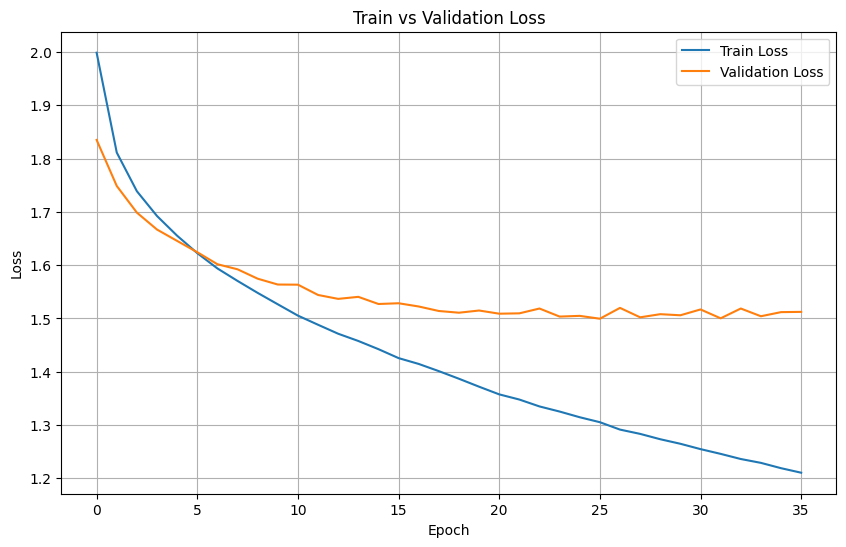

In [21]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(device)

cuda


In [22]:
#@title Defining metrics helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [23]:
#@title Evaluate model (accuracy, precision, recall)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

mlp = MLP(input_size,
          hidden1= hidden1,
          hidden2= hidden2,
          num_classes = 10,
          activation_function = activation_function)

mlp.to(device)

if os.path.exists("melhor_modelo.pth"):
    mlp.load_state_dict(torch.load("melhor_modelo.pth"))
    print("Pesos carregados com sucesso.")
else:
    print("Arquivo de pesos não encontrado. Modelo será inicializado do zero.")

mlp.eval()
predictions = []
labels = []
for images, label in val_loader:
  images = images.view(-1,input_size).to(device)
  label = label.to(device)

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

cuda
Pesos carregados com sucesso.
Scores of your model
 {'accuracy': 0.5533, 'balanced_accuracy': np.float64(0.5532999999999999), 'precision': 0.5549836670738871, 'recall': 0.5533, 'f1_score': 0.5521826788849169}


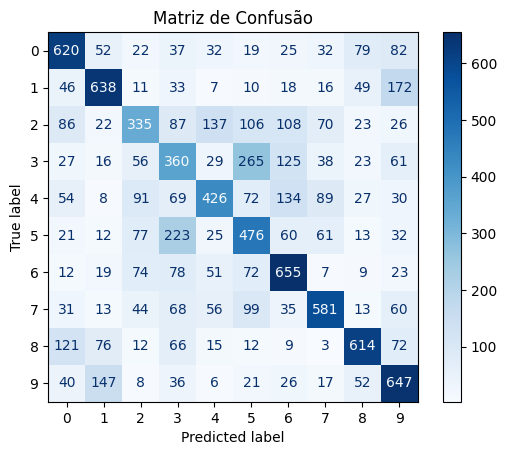

In [ ]:
cm = confusion_matrix(labels, predictions)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)  # pode mudar o colormap se quiser
plt.title("Matriz de Confusão")
plt.show()

In [ ]:
for label in range(10):
    print(f"{label}: {test_dataset.classes[label]}")

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92526716..1.0537698].


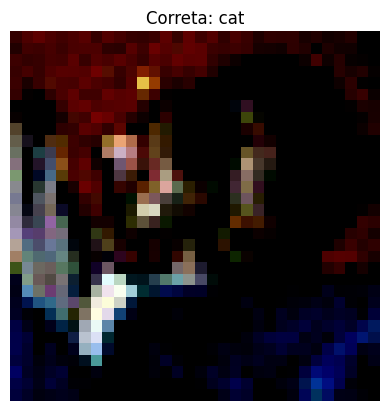

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1052287..1.0334064].


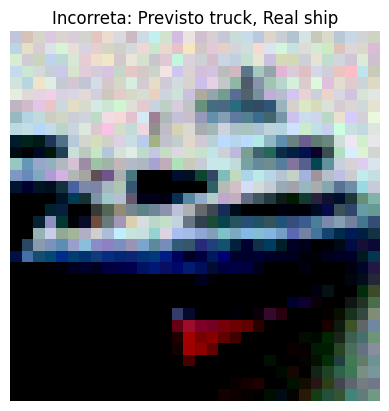

In [ ]:
# Lista com nomes das classes (exemplo para CIFAR-10)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Detecta o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move o modelo para o dispositivo
mlp.to(device)
mlp.eval()

correct_image = None
incorrect_image = None

# Sem gradientes para avaliação
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = mlp(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            if preds[i] == labels[i] and correct_image is None:
                correct_image = images[i].cpu()
                correct_label = labels[i].cpu()
                predicted_correct = preds[i].cpu()
            elif preds[i] != labels[i] and incorrect_image is None:
                incorrect_image = images[i].cpu()
                true_label = labels[i].cpu()
                predicted_incorrect = preds[i].cpu()

            if correct_image is not None and incorrect_image is not None:
                break
        if correct_image is not None and incorrect_image is not None:
            break

# Função para exibir imagem
def show_image(img_tensor, title=""):
    img = img_tensor.permute(1, 2, 0)  # de (C, H, W) para (H, W, C)
    plt.imshow(img.numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

# Mostra imagens com nomes das classes
show_image(correct_image, f"Correta: {class_names[predicted_correct.item()]}")
show_image(incorrect_image, f"Incorreta: Previsto {class_names[predicted_incorrect.item()]}, Real {class_names[true_label.item()]}")


# You can change/optimize this as you want
- Different optimizers, activation functions, etc
- Automatic hyperparameters optimization (Optuna)
- Regularization techniques
- Validation set to track metrics during epochs
- Transform input data
- ...